In [1]:
import imageio 
from matplotlib import pyplot as plt
from skimage import data, io
import ipywidgets as widgets
from ipywidgets import Button, Layout
#from SimpleCV import Image
import cv2
from skimage import data, io, filters, exposure
import skimage.morphology as mp
import numpy as np
from skimage.filters import roberts, sobel, scharr, prewitt, frangi, try_all_threshold, threshold_otsu, threshold_local
from skimage import img_as_float
from skimage.color import rgb2hsv, hsv2rgb, rgb2gray
import cv2
import numpy as np

In [2]:
style = {'description_width': '40%'}

selector = widgets.Dropdown(
    options=[('Healthy eye 1', 'photos/01_h.jpg'), ('Healthy eye 2', 'photos/02_h.jpg'), 
             ('Healthy eye 3', 'photos/03_h.jpg'), ('Healthy eye 4', 'photos/04_h.jpg'),
            ('Healthy eye 5', 'photos/05_h.jpg'), ('Healthy eye 6', 'photos/06_h.jpg'),
            ('Healthy eye 7', 'photos/07_h.jpg'), ('Healthy eye 8', 'photos/08_h.jpg'), 
            ('Healthy eye 9', 'photos/09_h.jpg'), ('Healthy eye 10', 'photos/10_h.jpg'),
            ('Healthy eye 11', 'photos/11_h.jpg'), ('Healthy eye 12', 'photos/12_h.jpg'), 
            ('Healthy eye 13', 'photos/13_h.jpg'), ('Healthy eye 14', 'photos/14_h.jpg'), 
            ('Healthy eye 15', 'photos/15_h.jpg')],
    value='photos/01_h.jpg',
    description='Image:',
    layout=Layout(width='50%', height='30px'),
    style=style
)

display(selector)

Dropdown(description='Image:', layout=Layout(height='30px', width='50%'), options=(('Healthy eye 1', 'photos/0…

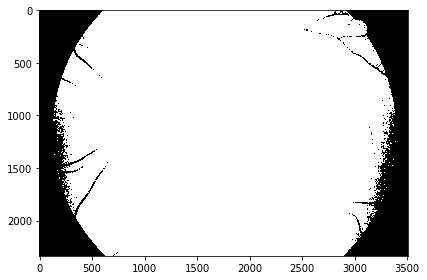

In [6]:
image = img_as_float(cv2.imread(selector.value))
def create_mask(image):
    img = rgb2gray(image)
    img[img[:, :] > 0.1] = 1
    img[img[:, :] <= 0.1] = 0
    return img
img = create_mask(image)
io.imshow(img)

In [7]:
img = cv2.imread(selector.value,0)
equ = cv2.equalizeHist(img)
# create a CLAHE object (Arguments are optional)
#CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(img)
#Zsres2 = np.hstack((img,cl1))
#cv2.imwrite('hist_clahe1.jpg',cl1)


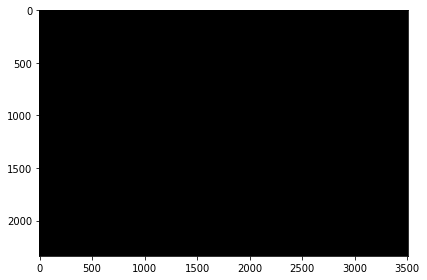

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1)
edges = filters.sobel(img)

low = 0.1
high = 0.35

lowt = (edges > high).astype(int)
io.imshow(lowt)

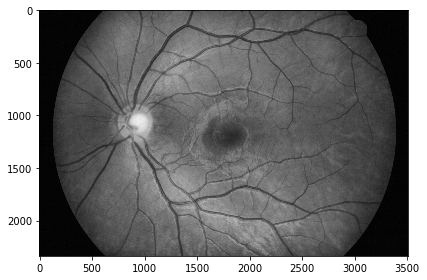

In [9]:
io.imshow(cl1)

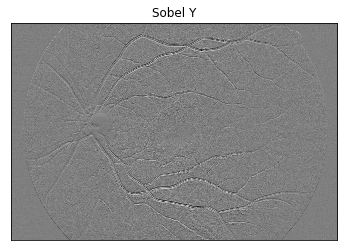

In [10]:
laplacian = cv2.Laplacian(cl1,cv2.CV_64F)
sobelx = cv2.Sobel(cl1,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(cl1,cv2.CV_64F,0,1,ksize=5)

plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()

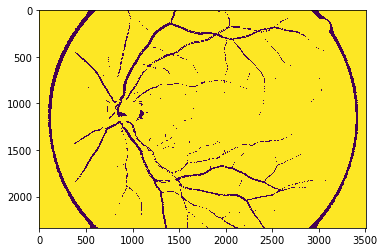

In [14]:
normalizedImg = np.zeros((800, 800))
normalizedImg = cv2.normalize(sobely,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
frangi_fajen = frangi(normalizedImg)
matrixp = []
for row in frangi_fajen:
    rowp = []
    for elem in row:
        if elem > 0.06:
            elem = 1
        else:
            elem = 0.0
        rowp.append(elem)
    matrixp.append(rowp)

    
block_size = 313
adaptive_thresh = threshold_local(img, block_size, offset=10)
binary_adaptive = img > adaptive_thresh

#new =  try_all_threshold(matrixp)
#fig, ax = try_all_threshold(normalizedImg, figsize=(10, 8), verbose=False)
#plt.show()
plt.imshow(binary_adaptive)
#print(frangi_fajen.max())
#print(frangi_fajen.min())
#print(frangi_fajen.mean())